In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import itertools
import heapq

In [ ]:
# --- 1. Graph Generation and Node Selection ---
def generate_graph_and_select_nodes(num_nodes,num_terminals):

    print("\n--- Generating Graph ---")
    G = nx.erdos_renyi_graph(n=num_nodes, p=0.2) # Erdos-Renyi graph

    for u, v in G.edges():
        G.edges[u, v]['weight'] = random.random() * 10 # Assign a random weight between 0 and 10

    pos = nx.spring_layout(G) # positions for all nodes

    print("\n--- Selecting Terminal Nodes ---")
    all_nodes = list(G.nodes())
    num_all_nodes = len(all_nodes)

    # Select terminals: Choose at least 2 terminals.
    # Ensure terminals are a subset of all nodes in G.
    terminals = random.sample(all_nodes, num_terminals)
    print(f"Selected Terminal nodes: {terminals}")
    steiner_nodes_potential = [node for node in all_nodes if node not in terminals]

    return G, terminals, steiner_nodes_potential, pos

G1, terminals1, steiner_nodes_potential1, pos1 = generate_graph_and_select_nodes(10,2)
G2, terminals2, steiner_nodes_potential2, pos2 = generate_graph_and_select_nodes(12,4)
G3, terminals3, steiner_nodes_potential3, pos3 = generate_graph_and_select_nodes(14,4)
G4, terminals4, steiner_nodes_potential4, pos4 = generate_graph_and_select_nodes(16,5)
G5, terminals5, steiner_nodes_potential5, pos5 = generate_graph_and_select_nodes(18,5)
G6, terminals6, steiner_nodes_potential6, pos6 = generate_graph_and_select_nodes(20,6)


--- Generating Graph ---

--- Selecting Terminal Nodes ---
Selected Terminal nodes: [8, 7]

--- Generating Graph ---

--- Selecting Terminal Nodes ---
Selected Terminal nodes: [5, 7, 6, 4]

--- Generating Graph ---

--- Selecting Terminal Nodes ---
Selected Terminal nodes: [5, 11, 4, 0]

--- Generating Graph ---

--- Selecting Terminal Nodes ---
Selected Terminal nodes: [2, 1, 4, 15, 10]

--- Generating Graph ---

--- Selecting Terminal Nodes ---
Selected Terminal nodes: [10, 1, 14, 8, 17]

--- Generating Graph ---

--- Selecting Terminal Nodes ---
Selected Terminal nodes: [11, 12, 10, 9, 5, 7]


In [ ]:


import time

def brute_force_steiner_tree(G, terminals, steiner_nodes_potential):
    """
    Solves the Steiner tree problem using a brute force approach.

    Args:
        G: A NetworkX graph with edge weights.
        terminals: A list of terminal nodes that must be included in the tree.
        steiner_nodes_potential: A list of potential Steiner nodes that can be included.

    Returns:
        A tuple containing:
            - A set of nodes forming the minimum Steiner tree found.
            - The total weight of the minimum Steiner tree.
            Returns (None, float('inf')) if no connected subgraph containing all terminals is found.
    """
    min_weight = float('inf')
    best_nodes = set()

    # Generate all possible combinations of potential steiner nodes
    for i in range(len(steiner_nodes_potential) + 1):
        for combo in itertools.combinations(steiner_nodes_potential, i):
            current_nodes = set(terminals).union(set(combo))

            # Create a subgraph with the current set of nodes
            subgraph = G.subgraph(current_nodes)

            # Check if the subgraph is connected and contains all terminals
            if nx.is_connected(subgraph):
                 if all(node in subgraph.nodes() for node in terminals):
                    # Calculate the MST of the subgraph
                    try:
                        mst = nx.minimum_spanning_tree(subgraph, weight='weight')
                        current_weight = sum(mst[u][v]['weight'] for u, v in mst.edges())

                        # Update minimum weight and best node set if a better MST is found
                        if current_weight < min_weight:
                            min_weight = current_weight
                            best_nodes = current_nodes
                    except nx.NetworkXNoCycle:
                         pass # Ignore disconnected components


    return best_nodes, min_weight


In [ ]:
# Apply brute force to the generated graphs
graphs = [(G1, terminals1, steiner_nodes_potential1),
          (G2, terminals2, steiner_nodes_potential2),
          (G3, terminals3, steiner_nodes_potential3),
          (G4, terminals4, steiner_nodes_potential4),
          (G5, terminals5, steiner_nodes_potential5),
          (G6, terminals6, steiner_nodes_potential6)]

brute_force_results = {}
for i, (graph, terms, steiner_potential) in enumerate(graphs):
    start_time = time.time()
    nodes, weight = brute_force_steiner_tree(graph, terms, steiner_potential)
    end_time = time.time()
    brute_force_results[f"Graph {i+1}"] = {"nodes": nodes, "weight": weight, "time": end_time - start_time}

# Display the results
for graph_name, result in brute_force_results.items():
    print(f"\n--- Brute Force Results for {graph_name} ---")
    if result['nodes']:
        print(f"  Minimum Steiner Tree Weight: {result['weight']:.2f}")
        print(f"  Steiner Tree Nodes: {result['nodes']}")
    else:
        print("  Could not find a connected subgraph containing all terminals.")
    print(f"  Time taken: {result['time']:.4f} seconds")


--- Brute Force Results for Graph 1 ---
  Minimum Steiner Tree Weight: 9.74
  Steiner Tree Nodes: {8, 2, 7}
  Time taken: 0.0152 seconds

--- Brute Force Results for Graph 2 ---
  Minimum Steiner Tree Weight: 29.82
  Steiner Tree Nodes: {0, 2, 3, 4, 5, 6, 7}
  Time taken: 0.0109 seconds

--- Brute Force Results for Graph 3 ---
  Minimum Steiner Tree Weight: 46.86
  Steiner Tree Nodes: {0, 1, 3, 4, 5, 6, 8, 9, 11, 13}
  Time taken: 0.0547 seconds

--- Brute Force Results for Graph 4 ---
  Minimum Steiner Tree Weight: 37.18
  Steiner Tree Nodes: {1, 2, 4, 6, 8, 10, 11, 15}
  Time taken: 0.1676 seconds

--- Brute Force Results for Graph 5 ---
  Minimum Steiner Tree Weight: 35.03
  Steiner Tree Nodes: {1, 17, 6, 8, 10, 14}
  Time taken: 3.3950 seconds

--- Brute Force Results for Graph 6 ---
  Minimum Steiner Tree Weight: 17.63
  Steiner Tree Nodes: {5, 6, 7, 8, 9, 10, 11, 12, 16}
  Time taken: 3.2062 seconds


In [ ]:
# --- 4. KMB Algorithm Implementation ---

import time
start_time_kmb = time.time()

def kmb_steiner_tree(G, terminals):
    """
    Solves the Steiner tree problem using the Kou, Markowsky, and Berman (KMB) approximation algorithm.

    Args:
        G: A NetworkX graph with non-negative edge weights.
        terminals: A list of terminal nodes that must be included in the tree.

    Returns:
        A tuple containing:
            - A set of nodes forming the approximate Steiner tree found.
            - A list of edges forming the approximate Steiner tree found.
            - The total weight of the approximate Steiner tree.
            Returns (set(), [], float('inf')) if terminals are less than 2 or no paths exist between terminals.
    """
    if len(terminals) < 2:
        print("KMB algorithm requires at least two terminal nodes.")
        return set(), [], float('inf')

    # 1. Compute all-pairs shortest paths between all terminal nodes
    terminal_pairs_shortest_paths = {}
    terminal_pairs_shortest_distances = {}

    for i in range(len(terminals)):
        for j in range(i + 1, len(terminals)):
            source = terminals[i]
            target = terminals[j]
            try:
                path = nx.shortest_path(G, source=source, target=target, weight='weight')
                distance = nx.shortest_path_length(G, source=source, target=target, weight='weight')

                terminal_pairs_shortest_paths[(source, target)] = path
                terminal_pairs_shortest_paths[(target, source)] = list(reversed(path))
                terminal_pairs_shortest_distances[(source, target)] = distance
                terminal_pairs_shortest_distances[(target, source)] = distance

            except nx.NetworkXNoPath:
                print(f"Warning: No path found between terminal nodes {source} and {target}. KMB might not find a connected tree.")


    # 2. Construct the metric closure graph
    metric_closure_graph = nx.Graph()
    metric_closure_graph.add_nodes_from(terminals)

    for (u, v), dist in terminal_pairs_shortest_distances.items():
        if u < v:
             metric_closure_graph.add_edge(u, v, weight=dist)

    if not nx.is_connected(metric_closure_graph):
         print("Warning: Metric closure graph is not connected. Not all terminals are reachable from each other.")
         return set(), [], float('inf')


    # 3. Compute the Minimum Spanning Tree (MST) of the metric closure graph
    try:
        mst_metric_closure = nx.minimum_spanning_tree(metric_closure_graph, weight='weight')




    except nx.NetworkXNoCycle:
         print("Error: Could not compute MST of the metric closure graph.")
         return set(), [], float('inf')


    # 4. Combine all nodes and edges from the shortest paths in the original graph G
    # corresponding to the edges in the MST of the metric closure graph.
    combined_subgraph_nodes = set()
    combined_subgraph_edges = set()

    for u, v in mst_metric_closure.edges():
        path = terminal_pairs_shortest_paths.get((u, v))
        if path is None:
            path = terminal_pairs_shortest_paths.get((v, u))

        if path:
            combined_subgraph_nodes.update(path)
            path_edges = list(nx.utils.pairwise(path))
            for edge_u, edge_v in path_edges:
                 combined_subgraph_edges.add(tuple(sorted((edge_u, edge_v))))

    # Create a subgraph from the combined nodes and edges
    final_kmb_subgraph = nx.Graph()
    final_kmb_subgraph.add_nodes_from(list(combined_subgraph_nodes))
    for u, v in combined_subgraph_edges:
        if G.has_edge(u, v):
            final_kmb_subgraph.add_edge(u, v, weight=G[u][v]['weight'])
        elif G.has_edge(v, u):
             final_kmb_subgraph.add_edge(v, u, weight=G[v][u]['weight'])


    # 6. Compute the MST of this combined subgraph
    if not nx.is_connected(final_kmb_subgraph):
         print("Error: Final combined subgraph is not connected.")
         return set(), [], float('inf')

    try:
        kmb_mst = nx.minimum_spanning_tree(final_kmb_subgraph, weight='weight')
        final_kmb_tree_nodes = set(kmb_mst.nodes())
        final_kmb_tree_edges = list(kmb_mst.edges())
        final_kmb_weight = sum(kmb_mst[u][v]['weight'] for u, v in kmb_mst.edges())

        if all(term in final_kmb_tree_nodes for term in terminals):
             return final_kmb_tree_nodes, final_kmb_tree_edges, final_kmb_weight
        else:
             print("Error: Not all terminals are included in the final KMB MST.")
             return set(), [], float('inf')

    except nx.NetworkXNoCycle:
         print("Error: Could not compute MST of the final KMB subgraph.")
         return set(), [], float('inf')



In [ ]:
# Apply KMB to the generated graphs
graphs = [(G1, terminals1), (G2, terminals2), (G3, terminals3),
          (G4, terminals4), (G5, terminals5), (G6, terminals6)]

kmb_results = {}
for i, (graph, terms) in enumerate(graphs):
    start_time_kmb = time.time()
    kmb_tree_nodes, kmb_tree_edges, kmb_weight = kmb_steiner_tree(graph, terms)
    end_time_kmb = time.time()
    kmb_results[f"Graph {i+1}"] = {"nodes": kmb_tree_nodes, "weight": kmb_weight, "time": end_time_kmb - start_time_kmb}

# Display the KMB results
for graph_name, result in kmb_results.items():
    print(f"\n--- KMB Results for {graph_name} ---")
    if result['nodes']:
        print(f"  KMB Approximate Steiner Tree Weight: {result['weight']:.2f}")
        print(f"  KMB Approximate Steiner Tree Nodes: {result['nodes']}")
    else:
        print("  KMB Algorithm: Could not find a connected tree containing all terminals.")
    print(f"  Time taken: {result['time']:.4f} seconds")


--- KMB Results for Graph 1 ---
  KMB Approximate Steiner Tree Weight: 9.74
  KMB Approximate Steiner Tree Nodes: {8, 2, 7}
  Time taken: 0.0005 seconds

--- KMB Results for Graph 2 ---
  KMB Approximate Steiner Tree Weight: 29.82
  KMB Approximate Steiner Tree Nodes: {0, 2, 3, 4, 5, 6, 7}
  Time taken: 0.0006 seconds

--- KMB Results for Graph 3 ---
  KMB Approximate Steiner Tree Weight: 51.82
  KMB Approximate Steiner Tree Nodes: {0, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13}
  Time taken: 0.0012 seconds

--- KMB Results for Graph 4 ---
  KMB Approximate Steiner Tree Weight: 37.18
  KMB Approximate Steiner Tree Nodes: {1, 2, 4, 6, 8, 10, 11, 15}
  Time taken: 0.0013 seconds

--- KMB Results for Graph 5 ---
  KMB Approximate Steiner Tree Weight: 35.03
  KMB Approximate Steiner Tree Nodes: {1, 6, 8, 10, 14, 17}
  Time taken: 0.0012 seconds

--- KMB Results for Graph 6 ---
  KMB Approximate Steiner Tree Weight: 17.63
  KMB Approximate Steiner Tree Nodes: {5, 6, 7, 8, 9, 10, 11, 12, 16}
  Time tak

In [ ]:
import heapq
import networkx as nx
import time

def greedy_steiner_tree(G, terminals):
    """
    Optimized Greedy Steiner Tree:
    - Retains greedy expansion nature.
    - Much faster than naive greedy and KMB.
    """
    if not terminals:
        return set(), [], float('inf')

    start_time = time.time()

    # Initialize structures
    tree_nodes = {terminals[0]}
    connected_terminals = {terminals[0]}
    tree_edges = set()
    total_weight = 0.0

    # Mark all nodes initially unvisited
    visited = {n: False for n in G.nodes()}
    for t in tree_nodes:
        visited[t] = True

    # Priority queue: (weight, u, v)
    pq = []
    for u in tree_nodes:
        for v, data in G[u].items():
            heapq.heappush(pq, (data['weight'], u, v))

    while connected_terminals != set(terminals) and pq:
        w, u, v = heapq.heappop(pq)

        if visited[v]:
            continue

        # Add new node/edge to the tree
        visited[v] = True
        tree_edges.add(tuple(sorted((u, v))))
        tree_nodes.add(v)
        total_weight += w

        if v in terminals:
            connected_terminals.add(v)

        # Add v’s neighbors to the heap
        for nbr, data in G[v].items():
            if not visited[nbr]:
                heapq.heappush(pq, (data['weight'], v, nbr))

    # Optional: prune unnecessary nodes (non-terminal leaves)
    pruned_tree = nx.Graph()
    pruned_tree.add_edges_from(tree_edges)
    pruned_tree = prune_non_terminal_leaves(pruned_tree, terminals)

    total_weight = sum(G[u][v]['weight'] for u, v in pruned_tree.edges())

    return set(pruned_tree.nodes()), list(pruned_tree.edges()), total_weight


def prune_non_terminal_leaves(G_sub, terminals):
    """
    Removes non-terminal leaves to reduce unnecessary nodes in the greedy tree.
    """
    changed = True
    while changed:
        changed = False
        leaves = [n for n in G_sub.nodes() if G_sub.degree(n) == 1 and n not in terminals]
        if leaves:
            G_sub.remove_nodes_from(leaves)
            changed = True
    return G_sub


In [ ]:
# Apply Greedy algorithm to the generated graphs
graphs = [(G1, terminals1), (G2, terminals2), (G3, terminals3),
          (G4, terminals4), (G5, terminals5), (G6, terminals6)]

greedy_results = {}
for i, (graph, terms) in enumerate(graphs):
    start_time_greedy = time.time()
    greedy_tree_nodes, greedy_tree_edges, greedy_weight = greedy_steiner_tree(graph, terms)
    end_time_greedy = time.time()
    greedy_results[f"Graph {i+1}"] = {"nodes": greedy_tree_nodes, "weight": greedy_weight, "time": end_time_greedy - start_time_greedy}

# Display the Greedy results
for graph_name, result in greedy_results.items():
    print(f"\n--- Greedy Results for {graph_name} ---")
    if result['nodes']:
        print(f"  Greedy Approximate Steiner Tree Weight: {result['weight']:.2f}")
        print(f"  Greedy Approximate Steiner Tree Nodes: {result['nodes']}")
    else:
        print("  Greedy Algorithm: Could not find a connected tree containing all terminals.")
    print(f"  Time taken: {result['time']:.4f} seconds")


--- Greedy Results for Graph 1 ---
  Greedy Approximate Steiner Tree Weight: 9.74
  Greedy Approximate Steiner Tree Nodes: {8, 2, 7}
  Time taken: 0.0001 seconds

--- Greedy Results for Graph 2 ---
  Greedy Approximate Steiner Tree Weight: 29.82
  Greedy Approximate Steiner Tree Nodes: {0, 2, 3, 4, 5, 6, 7}
  Time taken: 0.0001 seconds

--- Greedy Results for Graph 3 ---
  Greedy Approximate Steiner Tree Weight: 51.82
  Greedy Approximate Steiner Tree Nodes: {0, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13}
  Time taken: 0.0001 seconds

--- Greedy Results for Graph 4 ---
  Greedy Approximate Steiner Tree Weight: 41.94
  Greedy Approximate Steiner Tree Nodes: {1, 2, 4, 5, 6, 8, 10, 11, 15}
  Time taken: 0.0001 seconds

--- Greedy Results for Graph 5 ---
  Greedy Approximate Steiner Tree Weight: 41.68
  Greedy Approximate Steiner Tree Nodes: {1, 3, 4, 6, 7, 8, 10, 14, 16, 17}
  Time taken: 0.0002 seconds

--- Greedy Results for Graph 6 ---
  Greedy Approximate Steiner Tree Weight: 19.79
  Greedy Appr

In [ ]:
comparison_results = {}
graphs = [(G1, terminals1, steiner_nodes_potential1), (G2, terminals2, steiner_nodes_potential2), (G3, terminals3, steiner_nodes_potential3),
          (G4, terminals4, steiner_nodes_potential4), (G5, terminals5, steiner_nodes_potential5), (G6, terminals6, steiner_nodes_potential6)]

# Dictionary to easily access terminals for calculating Steiner nodes later
graphs_terminals = {f"Graph {i+1}": terms for i, (_, terms, _) in enumerate(graphs)}


for i, (graph, terms, steiner_potential) in enumerate(graphs):
    graph_name = f"Graph {i+1}"
    comparison_results[graph_name] = {}

    # Get KMB results
    comparison_results[graph_name]['KMB'] = kmb_results[graph_name]

    # Get Greedy results
    comparison_results[graph_name]['Greedy'] = greedy_results[graph_name]

    # Run Brute Force and get results
    start_time_brute_force = time.time()
    brute_force_nodes, brute_force_weight = brute_force_steiner_tree(graph, terms, steiner_potential)
    end_time_brute_force = time.time()
    comparison_results[graph_name]['Brute Force'] = {
        "nodes": brute_force_nodes,
        "weight": brute_force_weight,
        "time": end_time_brute_force - start_time_brute_force
    }

    # Calculate Approximation Factor and Steiner Nodes for KMB and Greedy here
    brute_force_weight = comparison_results[graph_name]['Brute Force'].get('weight', float('inf'))
    terminals = graphs_terminals.get(graph_name, [])

    for algo in ['KMB', 'Greedy', 'Brute Force']: # Include Brute Force to calculate steiner nodes
        if algo in comparison_results[graph_name]:
            algo_weight = comparison_results[graph_name][algo].get('weight', float('inf'))
            algo_nodes = comparison_results[graph_name][algo].get('nodes', set())

            # Calculate Approximation Factor (only for KMB and Greedy against Brute Force)
            if algo != 'Brute Force' and algo_weight != float('inf') and brute_force_weight is not None and brute_force_weight > 0:
                approximation_factor = algo_weight / brute_force_weight
            else:
                approximation_factor = None # Brute Force is the baseline, no approx factor

            comparison_results[graph_name][algo]['approximation_factor'] = approximation_factor

            # Calculate number of Steiner nodes
            if algo_nodes:
                num_steiner_nodes = len(algo_nodes) - len(terminals)
                comparison_results[graph_name][algo]['steiner_nodes'] = num_steiner_nodes
            else:
                comparison_results[graph_name][algo]['steiner_nodes'] = 0


# Display the collected results (optional, for verification)
# for graph_name, results in comparison_results.items():
#     print(f"\n--- Comparison Results for {graph_name} ---")
#     for algo, data in results.items():
#         print(f"  {algo}: Weight={data['weight']:.2f}, Time={data['time']:.4f}s, Approx Factor={data['approximation_factor']:.2f if data['approximation_factor'] is not None else 'N/A'}, Steiner Nodes={data['steiner_nodes']}")

In [ ]:
import pandas as pd

comparison_data = []

# Get the number of nodes for each graph
graph_node_counts = {f"Graph {i+1}": graph.number_of_nodes() for i, (graph, _, _) in enumerate(graphs)}

for graph_name, results in comparison_results.items():
    num_nodes = graph_node_counts.get(graph_name, 'N/A') # Get the number of nodes
    for algo_name, metrics in results.items():
        comparison_data.append({
            'Graph': graph_name, # Keep graph name for now to verify
            'Number of Nodes': num_nodes, # Add number of nodes
            'Algorithm': algo_name,
            'Weight': metrics.get('weight', float('inf')),
            'Runtime (s)': metrics.get('time', float('inf')),
            'Approximation Factor': metrics.get('approximation_factor'),
            'Steiner Nodes': metrics.get('steiner_nodes', 0)
        })

comparison_df = pd.DataFrame(comparison_data)

# Format the numerical columns for better readability
comparison_df['Weight'] = comparison_df['Weight'].apply(lambda x: f'{x:.2f}' if x != float('inf') else 'N/A')
comparison_df['Runtime (s)'] = comparison_df['Runtime (s)'].apply(lambda x: f'{x:.4f}' if x != float('inf') else 'N/A')
comparison_df['Approximation Factor'] = comparison_df['Approximation Factor'].apply(lambda x: f'{x:.2f}' if x is not None else 'N/A')

# Remove the original 'Graph' column and sort by number of nodes
comparison_df = comparison_df.drop('Graph', axis=1).sort_values(by='Number of Nodes').reset_index(drop=True)

print(comparison_df.to_string())

    Number of Nodes    Algorithm Weight Runtime (s) Approximation Factor  Steiner Nodes
0                10          KMB   9.74      0.0005                 1.00              1
1                10       Greedy   9.74      0.0001                 1.00              1
2                10  Brute Force   9.74      0.0129                  nan              1
3                12          KMB  29.82      0.0006                 1.00              3
4                12       Greedy  29.82      0.0001                 1.00              3
5                12  Brute Force  29.82      0.0087                  nan              3
6                14          KMB  51.82      0.0012                 1.11              7
7                14       Greedy  51.82      0.0001                 1.11              7
8                14  Brute Force  46.86      0.0580                  nan              6
9                16          KMB  37.18      0.0013                 1.00              3
10               16       Greedy

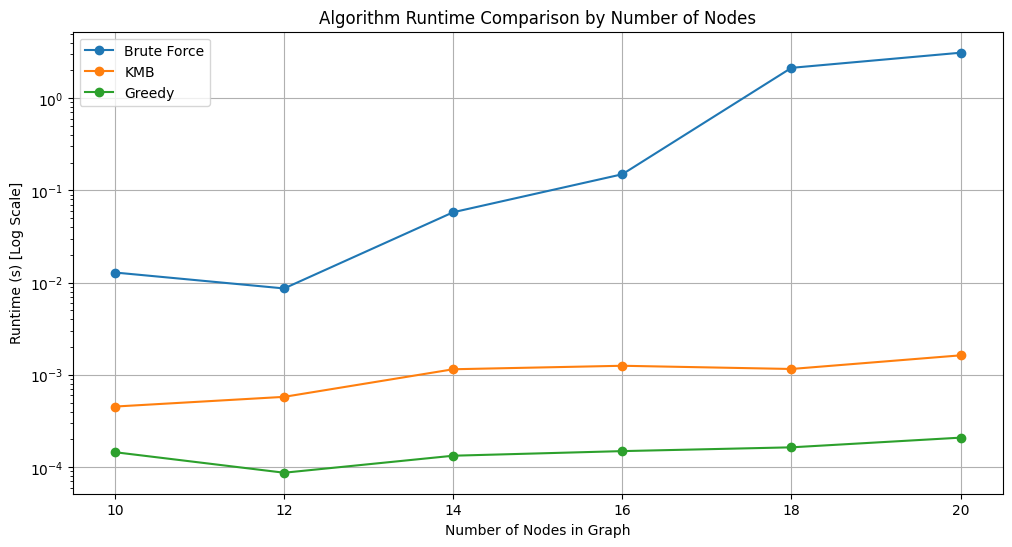

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
# Get the number of nodes for each graph
# Use the 'graphs' list which contains tuples of (graph, terminals, steiner_potential)
graph_node_counts = {f"Graph {i+1}": graph.number_of_nodes() for i, (graph, _, _) in enumerate(graphs)}
graph_names = list(comparison_results.keys())
algorithms = ['Brute Force', 'KMB', 'Greedy']

runtime_data = {algo: [] for algo in algorithms}
node_counts = []

for graph_name in graph_names:
    # Include Graph 6
    # if graph_name == 'Graph 6':
    #     continue
    for algo in algorithms:
        runtime = comparison_results[graph_name][algo]['time']
        runtime_data[algo].append(runtime if runtime != float('inf') else None)
    node_counts.append(graph_node_counts[graph_name])


# Create the plot with number of nodes on x-axis and log scale runtime on y-axis
plt.figure(figsize=(12, 6))

for algo in algorithms:
    # Filter out None values for plotting on log scale
    valid_runtimes = [rt for rt in runtime_data[algo] if rt is not None and rt > 0]
    valid_node_counts = [node_counts[i] for i, rt in enumerate(runtime_data[algo]) if rt is not None and rt > 0]
    plt.plot(valid_node_counts, valid_runtimes, marker='o', linestyle='-', label=algo)


plt.xlabel("Number of Nodes in Graph")
plt.ylabel("Runtime (s) [Log Scale]")
plt.title("Algorithm Runtime Comparison by Number of Nodes")
plt.yscale('log') # Set y-axis to log scale
plt.legend()
plt.grid(True)
plt.show()

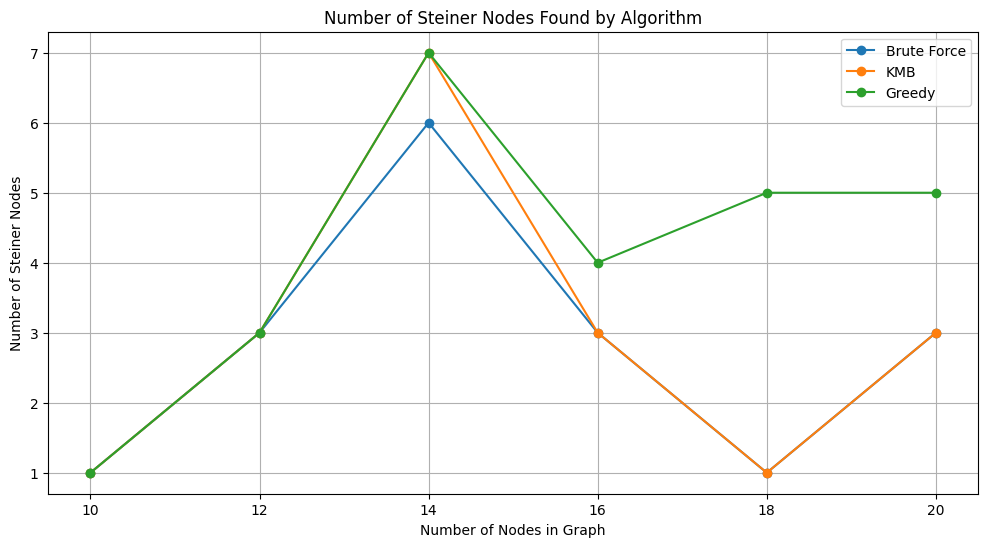

In [ ]:
import matplotlib.pyplot as plt

# Prepare data for plotting the number of Steiner nodes
graph_node_counts = {f"Graph {i+1}": graph.number_of_nodes() for i, (graph, _, _) in enumerate(graphs)}
graph_names = list(comparison_results.keys())
algorithms = ['Brute Force', 'KMB', 'Greedy']

steiner_nodes_data = {algo: [] for algo in algorithms}
node_counts = []

for graph_name in graph_names:
    for algo in algorithms:
        steiner_nodes = comparison_results[graph_name][algo]['steiner_nodes']
        steiner_nodes_data[algo].append(steiner_nodes if steiner_nodes is not None else 0) # Use 0 if not available
    node_counts.append(graph_node_counts[graph_name])

# Create the line chart for Steiner nodes
plt.figure(figsize=(12, 6))

for algo in algorithms:
    plt.plot(node_counts, steiner_nodes_data[algo], marker='o', linestyle='-', label=algo)

plt.xlabel("Number of Nodes in Graph")
plt.ylabel("Number of Steiner Nodes")
plt.title("Number of Steiner Nodes Found by Algorithm")
plt.legend()
plt.grid(True)
plt.show()

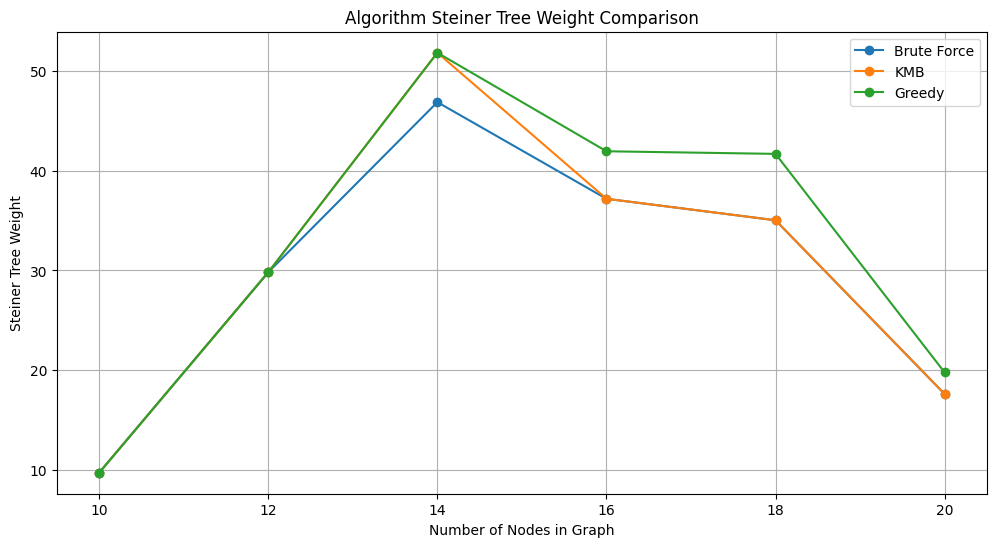

In [ ]:
import matplotlib.pyplot as plt

# Prepare data for plotting the tree weights
graph_node_counts = {f"Graph {i+1}": graph.number_of_nodes() for i, (graph, _, _) in enumerate(graphs)}
graph_names = list(comparison_results.keys())
algorithms = ['Brute Force', 'KMB', 'Greedy']

weight_data = {algo: [] for algo in algorithms}
node_counts = []

for graph_name in graph_names:
    for algo in algorithms:
        weight = comparison_results[graph_name][algo]['weight']
        weight_data[algo].append(weight if weight != float('inf') else None) # Use None if weight is inf
    node_counts.append(graph_node_counts[graph_name])

# Create the line chart for tree weights
plt.figure(figsize=(12, 6))

for algo in algorithms:
    # Filter out None values for plotting
    valid_weights = [w for w in weight_data[algo] if w is not None]
    valid_node_counts = [node_counts[i] for i, w in enumerate(weight_data[algo]) if w is not None]
    plt.plot(valid_node_counts, valid_weights, marker='o', linestyle='-', label=algo)

plt.xlabel("Number of Nodes in Graph")
plt.ylabel("Steiner Tree Weight")
plt.title("Algorithm Steiner Tree Weight Comparison")
plt.legend()
plt.grid(True)
plt.show()

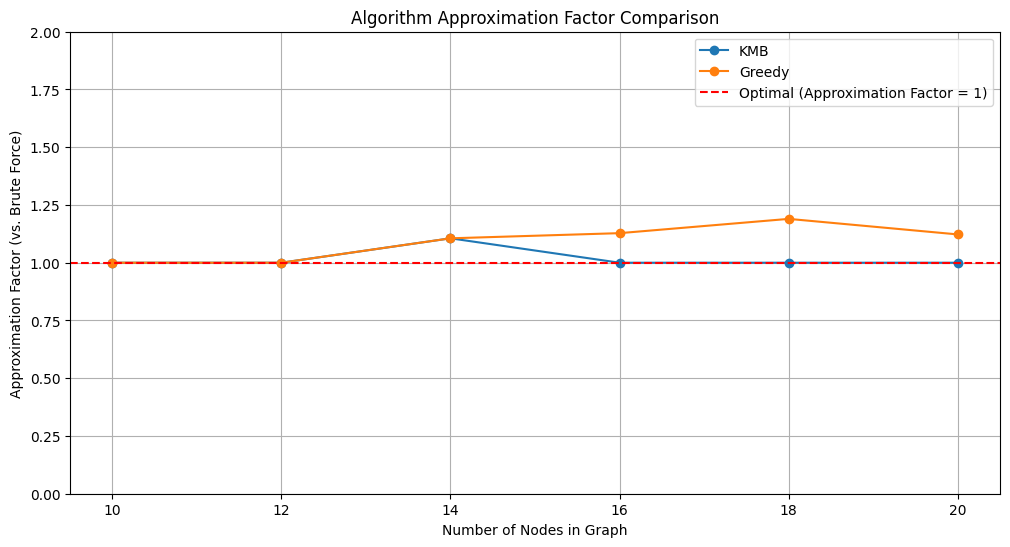

In [ ]:
import matplotlib.pyplot as plt

# Prepare data for plotting the approximation factors
graph_node_counts = {f"Graph {i+1}": graph.number_of_nodes() for i, (graph, _, _) in enumerate(graphs)}
graph_names = list(comparison_results.keys())
# Only KMB and Greedy have approximation factors relative to Brute Force
algorithms_to_plot = ['KMB', 'Greedy']

approximation_factor_data = {algo: [] for algo in algorithms_to_plot}
node_counts = []

for graph_name in graph_names:
    for algo in algorithms_to_plot:
        approx_factor = comparison_results[graph_name][algo].get('approximation_factor')
        approximation_factor_data[algo].append(approx_factor if approx_factor is not None else None) # Use None if not available
    node_counts.append(graph_node_counts[graph_name])

# Create the line chart for approximation factors
plt.figure(figsize=(12, 6))

for algo in algorithms_to_plot:
    # Filter out None values for plotting
    valid_approx_factors = [af for af in approximation_factor_data[algo] if af is not None]
    valid_node_counts = [node_counts[i] for i, af in enumerate(approximation_factor_data[algo]) if af is not None]
    plt.plot(valid_node_counts, valid_approx_factors, marker='o', linestyle='-', label=algo)

# Add a horizontal line at y=1 to represent the optimal approximation factor
plt.axhline(y=1.0, color='r', linestyle='--', label='Optimal (Approximation Factor = 1)')


plt.xlabel("Number of Nodes in Graph")
plt.ylabel("Approximation Factor (vs. Brute Force)")
plt.title("Algorithm Approximation Factor Comparison")
plt.legend()
plt.grid(True)
plt.ylim(0, 2) # Approximation factor is typically >= 1, but can be less than 2
plt.show()

In [ ]:
import time

# Generate a large graph and terminals
Graph, term, steiner_nodes_potential, pos = generate_graph_and_select_nodes(500,20)

# Calculate KMB result
print("\nSolving using KMB for the large graph...")
start_time_kmb = time.time()
kmb_tree_nodes, kmb_tree_edges, kmb_weight = kmb_steiner_tree(Graph, term)
end_time_kmb = time.time()
kmb_runtime = end_time_kmb - start_time_kmb

# Calculate Greedy result
print("\nSolving using Greedy for the large graph...")
start_time_greedy = time.time()
greedy_tree_nodes, greedy_tree_edges, greedy_weight = greedy_steiner_tree(Graph, term)
end_time_greedy = time.time()
greedy_runtime = end_time_greedy - start_time_greedy

# Display runtime comparison
print("\n--- Runtime Comparison for the Large Graph ---")
print(f"KMB Runtime: {kmb_runtime:.6f} seconds")
print(f"Greedy Runtime: {greedy_runtime:.6f} seconds")

# Optional: Display weights and number of nodes for comparison
# print("\n--- Weight and Node Comparison for the Large Graph ---")
# print(f"KMB Weight: {kmb_weight:.2f}")
# print(f"Greedy Weight: {greedy_weight:.2f}")
# print(f"KMB Nodes: {len(kmb_tree_nodes)}")
# print(f"Greedy Nodes: {len(greedy_tree_nodes)}")


--- Generating Graph ---

--- Selecting Terminal Nodes ---
Selected Terminal nodes: [148, 38, 356, 96, 440, 389, 70, 323, 345, 8, 125, 460, 157, 52, 9, 340, 358, 102, 147, 84]

Solving using KMB for the large graph...

Solving using Greedy for the large graph...

--- Runtime Comparison for the Large Graph ---
KMB Runtime: 3.460999 seconds
Greedy Runtime: 0.032040 seconds
